In [75]:
import pandas as pd
import numpy as np
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chisquare, norm


In [47]:
df = pd.read_csv("./data_ab.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [48]:
df.shape

(294478, 5)

# Шаг 1. EDA и подготовка


1. проверим дубликаты юзеров

In [49]:
len(df) == df["user_id"].nunique()

False

In [50]:
dupes = df["user_id"].value_counts()
dupes[dupes > 1]

user_id
805339    2
754884    2
722274    2
783176    2
898232    2
         ..
847058    2
889392    2
664150    2
835401    2
736955    2
Name: count, Length: 3894, dtype: int64

In [53]:
dupes_ids = dupes[dupes > 1].index
duplicate_rows = df[df["user_id"].isin(dupes_ids)]
duplicate_rows_sorted = duplicate_rows.sort_values(by="user_id")


duplicate_rows_sorted

,user_id,timestamp,group,landing_page,converted
230259,630052,2025-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2025-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2025-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2025-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2025-01-20 02:08:49.893878,control,old_page,0
...,...,...,...,...,...
142354,945703,2025-01-08 19:40:51.169351,control,new_page,0
186960,945797,2025-01-13 17:23:21.750962,control,old_page,0
40370,945797,2025-01-11 03:04:49.433736,control,new_page,1
165143,945971,2025-01-16 10:09:18.383183,control,old_page,0


In [54]:
#часть дубликатов

(7788/294478)*100

2.6446797383845313

In [55]:
#удаляем дубликаты
# найдём user_id, которые встречаются > 1 раза
dupes_ids = df["user_id"].value_counts()
dupes_ids = dupes_ids[dupes_ids > 1].index

# удалим ВСЕ строки этих пользователей из df
df_clean = df[~df["user_id"].isin(dupes_ids)].copy()

df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


2. удаляем несовпадения

In [56]:
df_clean = df[
    ((df["group"] == "treatment") & (df["landing_page"] == "new_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "old_page"))
]
df_clean

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [57]:
len(df) - len(df_clean)

3893

In [58]:
df_final = df_clean.sort_values("timestamp").drop_duplicates(subset="user_id", keep="first")
df_final.shape

(290584, 5)

In [59]:
df = df_final

3. делим на 2 датасета один - df_control, второй - df_treatment

In [60]:
df_control = df[df["group"]=="control"]
df_control.head()

,user_id,timestamp,group,landing_page,converted
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0
112584,799109,2025-01-02 13:42:45.219901,control,old_page,0
126997,643921,2025-01-02 13:43:03.767329,control,old_page,1
189698,677659,2025-01-02 13:43:32.744957,control,old_page,0


In [61]:
df_treatment = df[df["group"]=="treatment"]
df_treatment.head()

,user_id,timestamp,group,landing_page,converted
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0
191378,762651,2025-01-02 13:42:28.522322,treatment,new_page,0
111830,722516,2025-01-02 13:42:34.033708,treatment,new_page,0


In [62]:
df_control.shape

(145274, 5)

In [63]:
df_treatment.shape

(145310, 5)

In [64]:
n_control = len(df_control)
n_treatment = len(df_treatment)
total = n_control + n_treatment

print("Control %:", n_control/total * 100)
print("Treatment %:", n_treatment/total * 100)

Control %: 49.99380557773312
Treatment %: 50.00619442226688


гипотеза: доли групп соответствуют ожидаемым

In [76]:
counts = df["group"].value_counts().reindex(["control","treatment"])
chi_srm, p_srm = chisquare(counts.values, f_exp=[counts.sum()/2]*2)

print("SRM chi2:", chi_srm)
print("SRM p-value:", p_srm)

SRM chi2: 0.004459984032155934
SRM p-value: 0.9467543681597944


Небольшая разница в размере групп — норма.
При случайном распределении и последующей очистке данных группы почти никогда
не получаются равными.
Главное, что перекос минимальный — значит сплит корректен.

# 2.проверка сплита

In [65]:
import pandas as pd
from scipy.stats import chi2_contingency

# выделяем день
df["date"] = pd.to_datetime(df["timestamp"]).dt.date

# считаем количество пользователей по дням и группам
daily_counts = (
    df.groupby(["date", "group"])["user_id"]
    .nunique()
    .unstack(fill_value=0)
)

daily_counts

group,control,treatment
date,,
2025-01-02,2859,2853
2025-01-03,6590,6618
2025-01-04,6578,6541
2025-01-05,6427,6505
2025-01-06,6606,6747
2025-01-07,6604,6609
2025-01-08,6687,6700
2025-01-09,6628,6615
2025-01-10,6654,6696


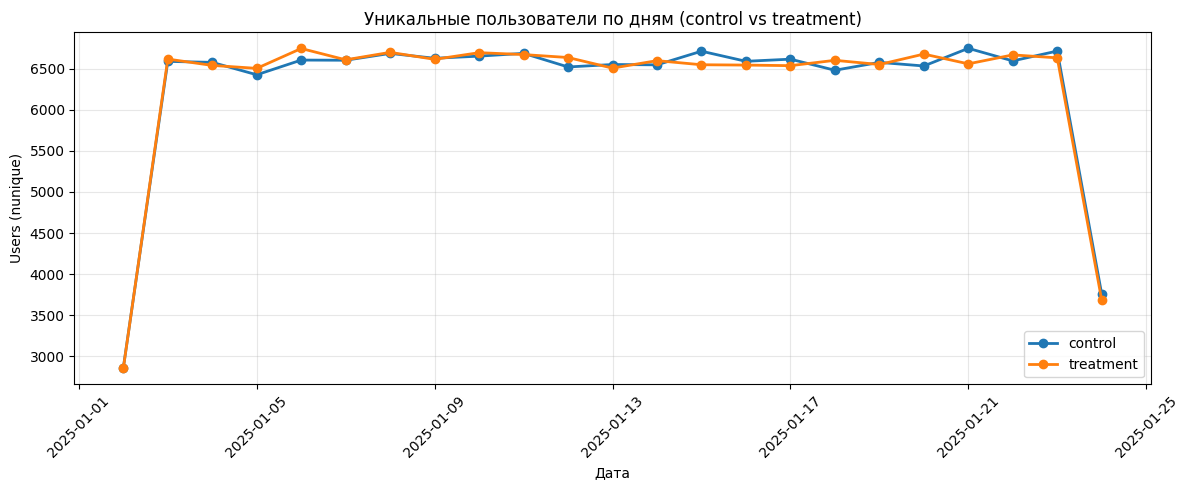

In [66]:
# на всякий случай приводим индекс к datetime
dc = daily_counts.copy()
dc.index = pd.to_datetime(dc.index)

plt.figure(figsize=(12, 5))
plt.plot(dc.index, dc["control"], marker="o", linewidth=2, label="control")
plt.plot(dc.index, dc["treatment"], marker="o", linewidth=2, label="treatment")

plt.title("Уникальные пользователи по дням (control vs treatment)")
plt.xlabel("Дата")
plt.ylabel("Users (nunique)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

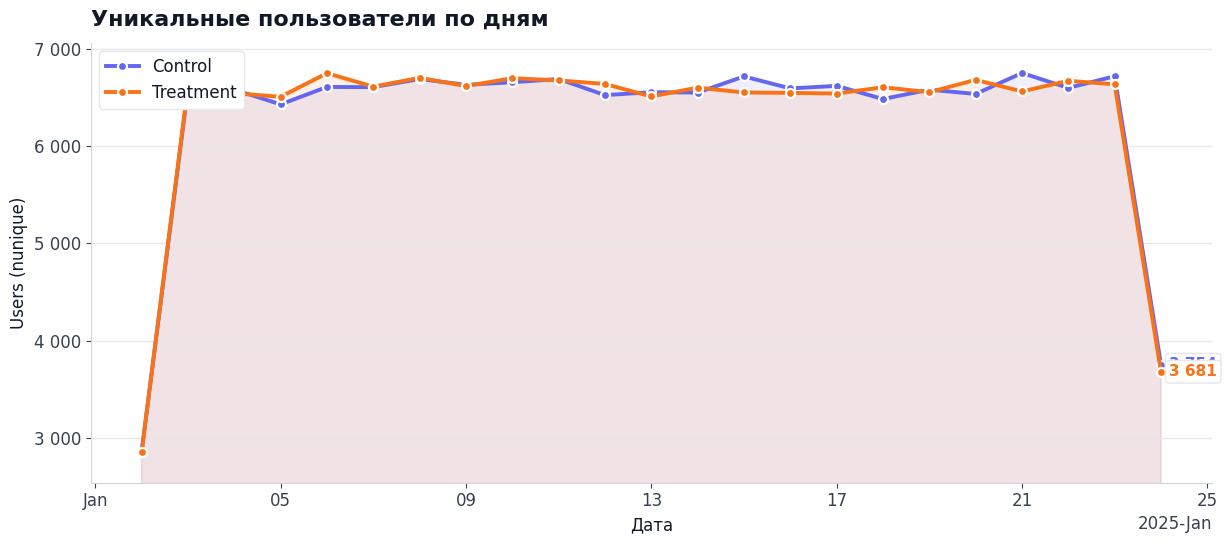

In [79]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd

# на всякий случай приводим индекс к datetime
dc = daily_counts.copy()
dc.index = pd.to_datetime(dc.index)

# --- Modern palette (в духе Tailwind) ---
C_CONTROL   = "#6366F1"  # indigo-500
C_TREATMENT = "#F97316"  # orange-500
GRID_COLOR  = "#E5E7EB"  # gray-200
TEXT_COLOR  = "#111827"  # gray-900

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#D1D5DB",
    "axes.labelcolor": TEXT_COLOR,
    "xtick.color": "#374151",
    "ytick.color": "#374151",
    "text.color": TEXT_COLOR,
    "font.size": 12,
})

fig, ax = plt.subplots(figsize=(12.5, 5.6))

# линии
ax.plot(dc.index, dc["control"],
        label="Control",
        color=C_CONTROL, linewidth=2.8,
        marker="o", markersize=6.5,
        markerfacecolor=C_CONTROL, markeredgecolor="white", markeredgewidth=1.6)

ax.plot(dc.index, dc["treatment"],
        label="Treatment",
        color=C_TREATMENT, linewidth=2.8,
        marker="o", markersize=6.5,
        markerfacecolor=C_TREATMENT, markeredgecolor="white", markeredgewidth=1.6)

# легкая заливка под линиями (очень “dashboard”)
ax.fill_between(dc.index, dc["control"].values, alpha=0.10, color=C_CONTROL)
ax.fill_between(dc.index, dc["treatment"].values, alpha=0.10, color=C_TREATMENT)

# сетка и спайны
ax.grid(True, axis="y", color=GRID_COLOR, linewidth=1.0, alpha=0.9)
ax.grid(False, axis="x")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# формат оси дат (красиво и без каши)
locator = mdates.AutoDateLocator(minticks=5, maxticks=9)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# формат Y: 12 345 вместо 12345
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", " ")))

# заголовок/подписи
ax.set_title("Уникальные пользователи по дням", loc="left", fontsize=16, pad=12, fontweight="bold")
ax.set_xlabel("Дата")
ax.set_ylabel("Users (nunique)")

# подпишем последние точки (очень читабельно в презентации)
def annotate_last(series, color, dx=6):
    x_last = dc.index[-1]
    y_last = float(series.iloc[-1])
    ax.annotate(f"{int(y_last):,}".replace(",", " "),
                xy=(x_last, y_last),
                xytext=(dx, 0),
                textcoords="offset points",
                va="center", ha="left",
                fontsize=11, fontweight="bold",
                color=color,
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#E5E7EB", lw=1))

annotate_last(dc["control"], C_CONTROL)
annotate_last(dc["treatment"], C_TREATMENT)

# легенда
leg = ax.legend(frameon=True, loc="upper left")
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("#E5E7EB")
leg.get_frame().set_alpha(1)

# адекватные отступы по Y
ymin = min(dc["control"].min(), dc["treatment"].min())
ymax = max(dc["control"].max(), dc["treatment"].max())
pad = (ymax - ymin) * 0.08 if ymax > ymin else 1
ax.set_ylim(ymin - pad, ymax + pad)

plt.tight_layout()
plt.show()

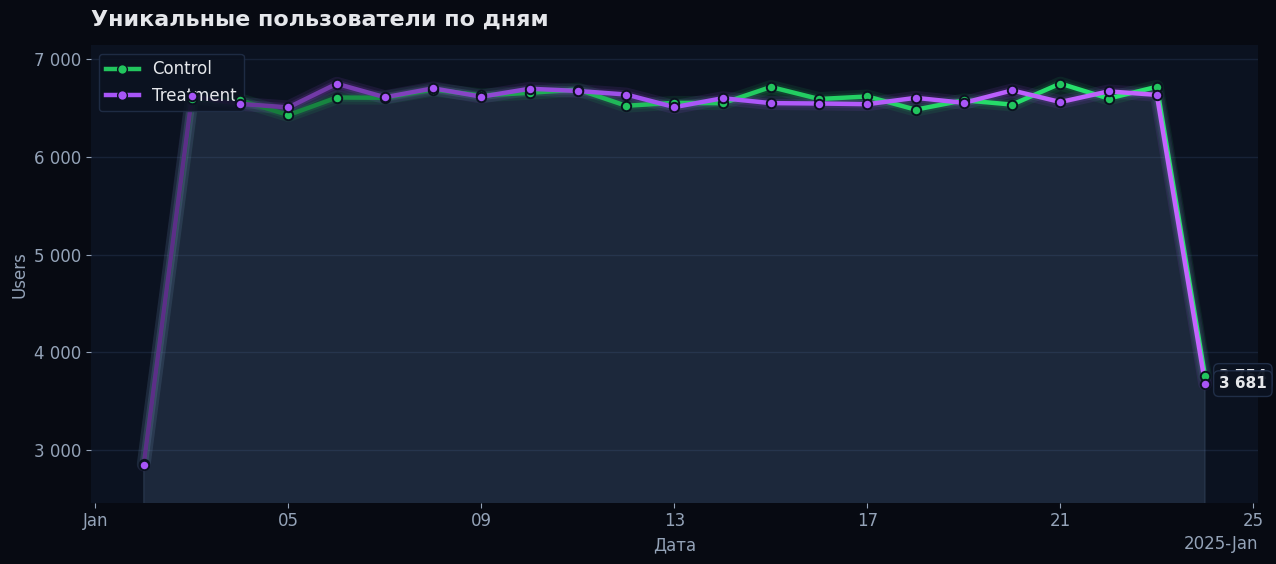

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

# --- data ---
dc = daily_counts.copy()
dc.index = pd.to_datetime(dc.index)

# --- ultra-modern palette ---
C_CONTROL   = "#22C55E"  # emerald
C_TREATMENT = "#A855F7"  # purple
BG          = "#070A12"  # near-black
PANEL       = "#0B1220"  # deep navy
GRID        = "#22304A"  # muted grid
TXT         = "#E5E7EB"  # light text
MUTED       = "#94A3B8"  # muted text

plt.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": PANEL,
    "axes.edgecolor": PANEL,
    "axes.labelcolor": MUTED,
    "xtick.color": MUTED,
    "ytick.color": MUTED,
    "text.color": TXT,
    "font.size": 12,
})

def y_fmt(x, _):
    return f"{int(x):,}".replace(",", " ")

def gradient_line(ax, x, y, base_color, lw=2.8, glow=True, zorder=3):
    x_num = mdates.date2num(pd.to_datetime(x))
    y = np.asarray(y, dtype=float)

    points = np.array([x_num, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    rgb = mcolors.to_rgb(base_color)
    dark  = tuple(max(0, c * 0.55) for c in rgb)
    light = tuple(min(1, c * 1.18) for c in rgb)
    cmap = mcolors.LinearSegmentedColormap.from_list("", [dark, rgb, light])

    if glow:
        ax.plot(x, y, color=base_color, linewidth=10, alpha=0.10,
                solid_capstyle="round", zorder=zorder-2)
        ax.plot(x, y, color=base_color, linewidth=6, alpha=0.12,
                solid_capstyle="round", zorder=zorder-1)

    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(0, 1))
    lc.set_array(np.linspace(0, 1, len(segments)))
    lc.set_linewidth(lw)
    lc.set_capstyle("round")
    lc.set_zorder(zorder)
    ax.add_collection(lc)

    # invisible line to keep autoscale working nicely
    ax.plot(x, y, alpha=0, zorder=1)
    return lc

fig, ax = plt.subplots(figsize=(13, 5.8))

x = dc.index
y_c = dc["control"].values
y_t = dc["treatment"].values

# gradient lines + glow
gradient_line(ax, x, y_c, C_CONTROL, lw=3.2, glow=True, zorder=5)
gradient_line(ax, x, y_t, C_TREATMENT, lw=3.2, glow=True, zorder=5)

# subtle area fills
ax.fill_between(x, y_c, color=C_CONTROL, alpha=0.10, zorder=2)
ax.fill_between(x, y_t, color=C_TREATMENT, alpha=0.10, zorder=2)

# premium markers (glass-like)
ax.scatter(x, y_c, s=46, color=C_CONTROL, edgecolor=PANEL, linewidth=1.4, zorder=6)
ax.scatter(x, y_t, s=46, color=C_TREATMENT, edgecolor=PANEL, linewidth=1.4, zorder=6)

# grid (only Y), minimal frame
ax.grid(True, axis="y", color=GRID, linewidth=1.0, alpha=0.55)
ax.grid(False, axis="x")
for spine in ax.spines.values():
    spine.set_visible(False)

# dates: concise, no rotation
locator = mdates.AutoDateLocator(minticks=5, maxticks=9)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

# y format
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))

# title + subtitle (как в продуктовой аналитике)
ax.set_title("Уникальные пользователи по дням", loc="left", fontsize=16, pad=14, fontweight="bold")

ax.set_xlabel("Дата")
ax.set_ylabel("Users")

# legend (glass card)
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color=C_CONTROL, lw=3.2, marker='o', markersize=7,
           markerfacecolor=C_CONTROL, markeredgecolor=PANEL, label="Control"),
    Line2D([0], [0], color=C_TREATMENT, lw=3.2, marker='o', markersize=7,
           markerfacecolor=C_TREATMENT, markeredgecolor=PANEL, label="Treatment"),
]
leg = ax.legend(handles=handles, loc="upper left", frameon=True, facecolor=PANEL,
                edgecolor=GRID, framealpha=0.85)
for t in leg.get_texts():
    t.set_color(TXT)

# last-point labels
def label_last(series, color):
    x_last = x[-1]
    y_last = float(series[-1])
    ax.annotate(
        f"{y_fmt(y_last, None)}",
        xy=(x_last, y_last),
        xytext=(10, 0),
        textcoords="offset points",
        va="center", ha="left",
        fontsize=11, fontweight="bold",
        color=TXT,
        bbox=dict(boxstyle="round,pad=0.35", fc=PANEL, ec=GRID, lw=1, alpha=0.95),
        zorder=10
    )

label_last(y_c, C_CONTROL)
label_last(y_t, C_TREATMENT)

# nice y padding
ymin = min(y_c.min(), y_t.min())
ymax = max(y_c.max(), y_t.max())
pad = (ymax - ymin) * 0.10 if ymax > ymin else 1
ax.set_ylim(ymin - pad, ymax + pad)

plt.tight_layout()
plt.show()

гипотеза - распределение пользователей по группам не зависит от дня

обоснование: используем тест хи-квадрат, чтобы показать, что разница между количеством пользователей в разные дни не зависит от дня, то есть случайна

In [67]:
# применяем χ²-тест
chi2, p, dof, expected = chi2_contingency(daily_counts)

print("Chi-square:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)

Chi-square: 13.420603994207953
p-value: 0.9207631079105322
Degrees of freedom: 22


гипотеза принимается

# Конверсия по дням в группе

In [69]:
import pandas as pd

df["date"] = pd.to_datetime(df["timestamp"]).dt.date

daily_cr = (
    df.groupby(["date", "group"])
      .agg(users=("user_id", "nunique"),
           conversions=("converted", "sum"))
      .assign(conversion_rate=lambda x: x["conversions"] / x["users"])
      .reset_index()
)
cr_table = daily_cr.pivot(index="date", columns="group", values="conversion_rate").round(4)

cr_table

group,control,treatment
date,,
2025-01-02,0.1256,0.1199
2025-01-03,0.1138,0.1138
2025-01-04,0.1219,0.1166
2025-01-05,0.1232,0.1150
2025-01-06,0.1153,0.1235
2025-01-07,0.1210,0.1162
2025-01-08,0.1189,0.1207
2025-01-09,0.1196,0.1181
2025-01-10,0.1129,0.1263


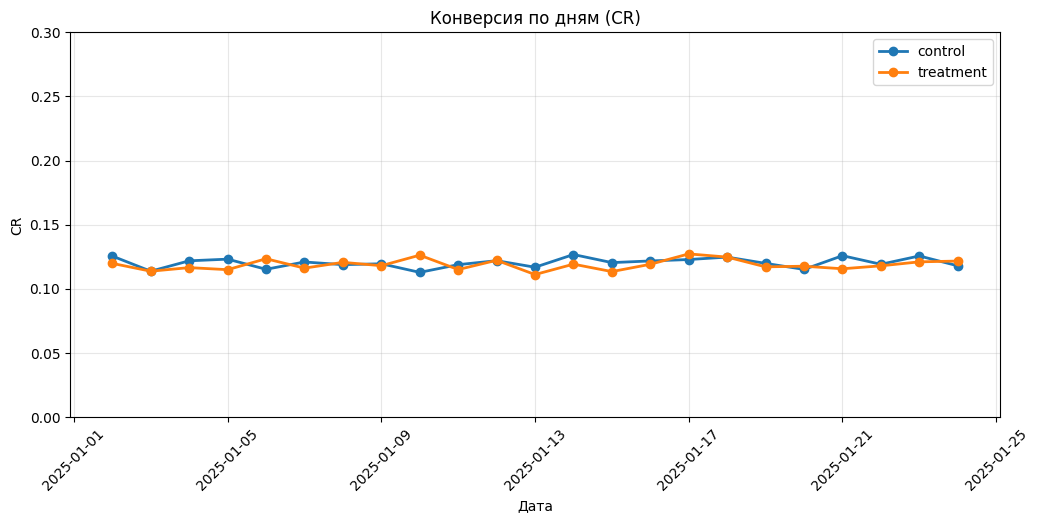

In [72]:
plot_df = cr_table.copy()
plot_df.index = pd.to_datetime(plot_df.index)

plt.figure(figsize=(12, 5))
plt.plot(plot_df.index, plot_df["control"], marker="o", linewidth=2, label="control")
plt.plot(plot_df.index, plot_df["treatment"], marker="o", linewidth=2, label="treatment")

plt.title("Конверсия по дням (CR)")
plt.xlabel("Дата")
plt.ylabel("CR")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.ylim(0, 0.3)
plt.show()

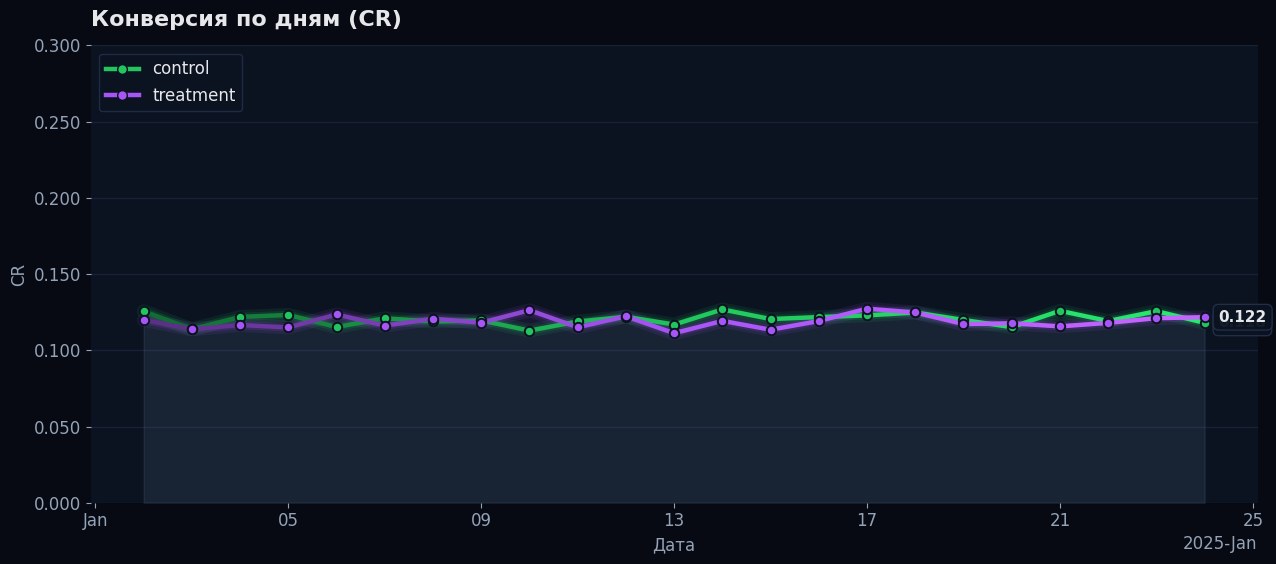

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

plot_df = cr_table.copy()
plot_df.index = pd.to_datetime(plot_df.index)

# --- ultra-modern palette ---
C_CONTROL   = "#22C55E"  # emerald
C_TREATMENT = "#A855F7"  # purple
BG          = "#070A12"
PANEL       = "#0B1220"
GRID        = "#22304A"
TXT         = "#E5E7EB"
MUTED       = "#94A3B8"

plt.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": PANEL,
    "axes.edgecolor": PANEL,
    "axes.labelcolor": MUTED,
    "xtick.color": MUTED,
    "ytick.color": MUTED,
    "text.color": TXT,
    "font.size": 12,
})

def gradient_line(ax, x, y, base_color, lw=3.0, glow=True, zorder=5):
    x_num = mdates.date2num(pd.to_datetime(x))
    y = np.asarray(y, dtype=float)

    points = np.array([x_num, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    rgb = mcolors.to_rgb(base_color)
    dark  = tuple(max(0, c * 0.55) for c in rgb)
    light = tuple(min(1, c * 1.18) for c in rgb)
    cmap = mcolors.LinearSegmentedColormap.from_list("", [dark, rgb, light])

    if glow:
        ax.plot(x, y, color=base_color, linewidth=10, alpha=0.10,
                solid_capstyle="round", zorder=zorder-2)
        ax.plot(x, y, color=base_color, linewidth=6, alpha=0.12,
                solid_capstyle="round", zorder=zorder-1)

    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(0, 1))
    lc.set_array(np.linspace(0, 1, len(segments)))
    lc.set_linewidth(lw)
    lc.set_capstyle("round")
    lc.set_zorder(zorder)
    ax.add_collection(lc)

    # keep autoscale sane
    ax.plot(x, y, alpha=0, zorder=1)

fig, ax = plt.subplots(figsize=(13, 5.8))

x = plot_df.index
y_c = plot_df["control"].values
y_t = plot_df["treatment"].values

# lines
gradient_line(ax, x, y_c, C_CONTROL, lw=3.2, glow=True)
gradient_line(ax, x, y_t, C_TREATMENT, lw=3.2, glow=True)

# subtle fills
ax.fill_between(x, y_c, color=C_CONTROL, alpha=0.08, zorder=2)
ax.fill_between(x, y_t, color=C_TREATMENT, alpha=0.08, zorder=2)

# markers
ax.scatter(x, y_c, s=46, color=C_CONTROL, edgecolor=PANEL, linewidth=1.4, zorder=6)
ax.scatter(x, y_t, s=46, color=C_TREATMENT, edgecolor=PANEL, linewidth=1.4, zorder=6)

# grid & frame
ax.grid(True, axis="y", color=GRID, linewidth=1.0, alpha=0.55)
ax.grid(False, axis="x")
for spine in ax.spines.values():
    spine.set_visible(False)

# date formatting
locator = mdates.AutoDateLocator(minticks=5, maxticks=9)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

# y formatting (CR)
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.3f}"))
ax.set_ylim(0, 0.3)   # как просил

# titles
ax.set_title("Конверсия по дням (CR)", loc="left", fontsize=16, pad=14, fontweight="bold")

ax.set_xlabel("Дата")
ax.set_ylabel("CR")

# legend (glass)
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color=C_CONTROL, lw=3.2, marker='o', markersize=7,
           markerfacecolor=C_CONTROL, markeredgecolor=PANEL, label="control"),
    Line2D([0], [0], color=C_TREATMENT, lw=3.2, marker='o', markersize=7,
           markerfacecolor=C_TREATMENT, markeredgecolor=PANEL, label="treatment"),
]
leg = ax.legend(handles=handles, loc="upper left", frameon=True, facecolor=PANEL,
                edgecolor=GRID, framealpha=0.85)
for t in leg.get_texts():
    t.set_color(TXT)

# labels on last points
def label_last(y, text):
    ax.annotate(
        text,
        xy=(x[-1], float(y[-1])),
        xytext=(10, 0),
        textcoords="offset points",
        va="center", ha="left",
        fontsize=11, fontweight="bold",
        color=TXT,
        bbox=dict(boxstyle="round,pad=0.35", fc=PANEL, ec=GRID, lw=1, alpha=0.95),
        zorder=10
    )

label_last(y_c, f"{y_c[-1]:.3f}")
label_last(y_t, f"{y_t[-1]:.3f}")

plt.tight_layout()
plt.show()

In [77]:
summary = (
    df_clean.groupby("group")
      .agg(users=("user_id","nunique"),
           conversions=("converted","sum"))
)
summary["cr"] = summary["conversions"] / summary["users"]
summary

,users,conversions,cr
group,,,
control,145274,17489,0.120386
treatment,145310,17264,0.118808


Гипотеза: Конверсия контроля равна конверсии в тесте

In [78]:
n_c = summary.loc["control","users"]
n_t = summary.loc["treatment","users"]
x_c = summary.loc["control","conversions"]
x_t = summary.loc["treatment","conversions"]

p_c = x_c / n_c
p_t = x_t / n_t
diff = p_t - p_c                 # абсолютная разница
uplift = p_t / p_c - 1           # относительная

# z-test (pooled)
p_pool = (x_c + x_t) / (n_c + n_t)
se = (p_pool*(1-p_pool)*(1/n_c + 1/n_t))**0.5
z = diff / se
p_value = 2*(1 - norm.cdf(abs(z)))

# 95% CI для diff (unpooled)
se_u = (p_c*(1-p_c)/n_c + p_t*(1-p_t)/n_t)**0.5
ci_low, ci_high = diff - 1.96*se_u, diff + 1.96*se_u

print("CR control:", p_c)
print("CR treatment:", p_t)
print("ΔCR (t-c):", diff, f"({diff*100:.2f} п.п.)")
print("Uplift:", uplift)
print("z:", z)
print("p-value:", p_value)
print("95% CI for ΔCR:", (ci_low, ci_high))

CR control: 0.1203863045004612
CR treatment: 0.11880806551510564
ΔCR (t-c): -0.0015782389853555567 (-0.16 п.п.)
Uplift: -0.013109788458948057
z: -1.3109241984234394
p-value: 0.18988337448195103
95% CI for ΔCR: (np.float64(-0.003937903604443846), np.float64(0.0007814256337327326))


коммент для нас

Здесь uplift = −1.31%, то есть treatment даёт конверсию примерно на 1.3% ниже, чем control (в относительных терминах).
Это вероятность (если на самом деле разницы нет, H0 верна) получить такое же или более сильное отклонение, как у вас, случайно.

	•	p = 0.19 > 0.05 ⇒ статзначимой разницы нет на уровне значимости 5%.

То есть по данным нельзя уверенно сказать, что treatment лучше/хуже control — наблюдаемая просадка может быть шумом.

95% доверительный интервал для истинной разницы CR_t - CR_c.

Переведём в п.п.:

	•	нижняя граница: −0.3938 п.п.
	•	верхняя граница: +0.0781 п.п.

Интерпретация:

	•	“С 95% уверенностью” истинный эффект treatment лежит между падением до −0.39 п.п. и ростом до +0.08 п.п.
	•	Так как интервал пересекает 0, это согласуется с выводом “значимости нет”.


Вывод:

	•	Статистически значимого эффекта не обнаружено (p-value > 0.05, интервал пересекает 0).
	•	Реальный эффект совместим как с небольшим минусом, так и с небольшим плюсом до ~+0.08 п.п., поэтому данных недостаточно, чтобы уверенно сказать улучшили или ухудшили фичу.